# Exploratory Data Analysis
### DATA301 | Group 3

Initial transformations on the **police** dataset and **employment** datasets are performed in `data_wrangling_data301.ipynb`. Running this notebook generates the files `police_dataset_clean.csv` and `employment_dataset_clean.csv` in the `/output` directory.

The police dataset contains detailed anonymized information about crime victimisations from 2014 to 2025. This can be accessed here: https://public.tableau.com/app/profile/policedata.nz/viz/VictimisationsPoliceStations/Summary. More details on how to run the data wrangling notebook are provided within the notebook. The employment dataset was required as one of the group members is analysing how employment rate is related to crime victimizations. The primary purpose of the `data_wrangling_data301.ipynb` notebook was to get these datasets in a format which can be joined.

## EDA Introduction

Data wrangling has already been performed to transform the police dataset to a suitable format for exploratory data analysis. The police dataset in its raw state was reasonably tidy, and the main data wrangling task was down-sampling the `Year Month` column from monthly to quarterly frequency. This was required as one of the group members' individual questions related to unemployment rates, and the unemployment reporting with the highest frequency from stats NZ is quarterly. We determined that interpolation was not appropriate as monthly frequency would require two extra datapoints to be inferred between each of the adjacent quarterly values. This may miss nuances in the trend, and complicate any modelling performed in subsequent steps of the project. The data-wrangling notebook can be found here: https://github.com/LennoxC/data301-group3-project/blob/main/data_wrangling_data301_eda.ipynb. Overall the police and employment datasets required minimal transformations and wrangling to be converted to a suitable format.



In [32]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import dataframe_image as dfi

In [33]:
# charts and tables will be saved to the `/images` directory
IMAGE_PATH = "images"

# call this when saving a figure to generate a file name
def get_output_path(figure_name):
    return os.path.join(IMAGE_PATH, figure_name)

# ensure the images directory exists
os.makedirs(IMAGE_PATH, exist_ok=True)

In [34]:
# load the datasets
police = pd.read_csv("output/police_dataset_clean.csv")
employment = pd.read_csv("output/employment_dataset_clean.csv")

C:\Users\lenno\AppData\Local\Temp\ipykernel_29120\1845274278.py:2: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  police = pd.read_csv("output/police_dataset_clean.csv")


### Initial Understanding of the Dataframes

The police dataset has the following structure:

In [35]:
police.head()

,Unnamed: 0,Anzsoc Division,Police Area/TA,Police District/TA,Police Station/TA,Location Type Description,Location Type Division,Person/Organisation,Weapons Used,Year Month,...,Police Boundary,Previous Period,Selected Period,Table 1,Variance,Weapon,year,quarter,quarter_start,Police District Merged
0,0,Burglary,Auckland Central Area,Auckland City,Auckland Central,Community Location N.E.C.,Community Location,Organisation,Not Applicable,2025-05-01,...,Auckland City,0,1,1 Age Ethnicity Boundary,1,Not Applicable,2025,2,2025-04-01,Auckland
1,1,Burglary,Auckland East Area,Auckland City,Glen Innes,Community Location N.E.C.,Community Location,Organisation,Not Applicable,2025-05-01,...,Auckland City,0,1,1 Age Ethnicity Boundary,1,Not Applicable,2025,2,2025-04-01,Auckland
2,2,Burglary,Auckland East Area,Auckland City,Newmarket,Community Location N.E.C.,Community Location,Organisation,Not Applicable,2025-05-01,...,Auckland City,0,1,1 Age Ethnicity Boundary,1,Not Applicable,2025,2,2025-04-01,Auckland
3,3,Burglary,Auckland West Area,Auckland City,Ponsonby,Community Location N.E.C.,Community Location,Organisation,Not Applicable,2025-05-01,...,Auckland City,0,1,1 Age Ethnicity Boundary,1,Not Applicable,2025,2,2025-04-01,Auckland
4,4,Burglary,Auckland Central Area,Auckland City,Auckland Central,Public Place,Community Location,Organisation,Not Applicable,2025-05-01,...,Auckland City,0,1,1 Age Ethnicity Boundary,1,Not Applicable,2025,2,2025-04-01,Auckland


In [36]:
df_police_head = pd.DataFrame(police.dtypes)

In [37]:
dfi.export(df_police_head, get_output_path("police_head.png"), table_conversion='matplotlib')

The police dataset is in long format. To find a trend of victimisations, the dataset will need to be grouped by an appropriate datatime column. This is a flexible way to store the dataframe, because it allows victimisation reporting across any of the other features of the dataframe. For example, to visualise victims of crimes involving different types of weapons, the dataframe should be grouped by 'month' and 'weapons used'.

The employment dataset has the following structure:

In [38]:
employment.head()

,Unnamed: 0,quarter_start,year,quarter,Period,Auckland,Bay Of Plenty,Canterbury,Eastern,Northland,Tasman,Total All Regional Councils,Waikato,Wellington
0,0,1986-01-01,1986,1,1986.03,66.10,61.7,64.0,64.40,59.80,61.20,64.30,63.60,67.30
1,1,1986-04-01,1986,2,1986.06,66.40,61.1,63.9,63.20,56.60,59.10,63.90,63.10,67.20
2,2,1986-07-01,1986,3,1986.09,67.20,60.2,62.8,58.90,57.60,62.30,63.60,62.30,66.40
3,3,1986-10-01,1986,4,1986.12,66.85,61.7,61.9,61.50,58.00,61.75,63.90,62.85,67.85
4,4,1987-01-01,1987,1,1987.03,67.20,61.3,61.5,61.85,58.05,62.15,63.85,63.10,67.30


In [39]:
df_employment_head = pd.DataFrame(employment.dtypes)
dfi.export(df_employment_head, get_output_path("employment_head.png"), table_conversion='matplotlib')

The employment dataset is already aggregated by quarter, and reports an employment statistic for all 10 regional council areas, along with a 'total' (nation-wide). The value being measured is the **percentage of the estimated working-age population who are employed**.

In [40]:
police['quarter_start'] = pd.to_datetime(police['quarter_start'])
employment['quarter_start'] = pd.to_datetime(employment['quarter_start'])

### Check for missing values

Most statistical models require a complete dataset with no missing values. The police and employment datasets should be queried for missing values.

In [41]:
police.notnull().sum()

Unnamed: 0                   1463366
Anzsoc Division              1463366
Police Area/TA               1463366
Police District/TA           1463366
Police Station/TA            1463366
Location Type Description    1463366
Location Type Division       1463366
Person/Organisation          1463366
Weapons Used                 1223500
Year Month                   1463366
Police Area                  1463366
Police District              1463366
Police Station               1463366
Territorial Authority        1463366
Victimisations               1463366
% Variance                    164419
%Variance                    1463362
Age Group                    1463366
Anzsoc Group                 1463366
Anzsoc Subdivision           1463366
Anzsoc Subgroup              1463366
Ethnic Group                 1463366
Ethnicity                    1463366
Location                     1463366
Location Type                1463366
Number of Records            1463366
Police   Boundary            1463366
P

In [42]:
employment.notnull().sum()

Unnamed: 0                     157
quarter_start                  157
year                           157
quarter                        157
Period                         157
Auckland                       157
Bay Of Plenty                  157
Canterbury                     157
Eastern                        157
Northland                      157
Tasman                         157
Total All Regional Councils    157
Waikato                        157
Wellington                     157
dtype: int64

In [43]:
df_police_missing = pd.DataFrame(police.notnull().sum())
dfi.export(df_police_missing, get_output_path("police_missing.png"), table_conversion='matplotlib')

df_employment_missing = pd.DataFrame(employment.notnull().sum())
dfi.export(df_employment_missing, get_output_path("employment_missing.png"), table_conversion='matplotlib')

The employment dataset does not contain any null values.

The police dataset contains null values in the following columns:
- `Weapons used`
- `% Variance` (and another column called `%Variance`)
- `Weapon`

In [44]:
police['Weapon'].value_counts()

Weapon
Not Applicable             940449
Not Stated                 216883
Other Weapon                26499
Blunt Instrument N.F.D.     16993
Sharp N.F.D.                10176
Firearm N.F.D.               4510
Knife                        2898
Blunt Instrument N.E.C.      2184
Sharp N.E.C.                  875
Bludgeon                      618
Handgun                       441
Shotgun                       407
Rifle                         207
Bottle/Glass                  160
Air Gun                        94
Firearm N.E.C.                 72
Replica Firearm                34
Name: count, dtype: int64

In [45]:
police['Weapons Used'].value_counts()

Weapons Used
Not Applicable             940449
Not Stated                 216883
Other Weapon                26499
Blunt Instrument            17611
Stabbing/Cutting Weapon     14109
Firearms                     5765
Blunt Instrument N.E.C.      2184
Name: count, dtype: int64

In [46]:
police[police['Weapons Used'].isnull()][['Weapon', 'Weapons Used']].head()

,Weapon,Weapons Used
119,NaN,NaN
120,NaN,NaN
121,NaN,NaN
122,NaN,NaN
123,NaN,NaN


In [47]:
df_police_missing_nan = pd.DataFrame(police[police['Weapons Used'].isnull()][['Weapon', 'Weapons Used']].head())
dfi.export(df_police_missing_nan, get_output_path("police_missing_nan.png"), table_conversion='matplotlib')

#### Handling the missing values

##### Weapons

There are five rows in the police dataset which contain missing values for both `Weapon` and `Weapons Used`. The null values for each column are the same set of records, so there are only five rows with missing values. There is an existing category in these columns called 'not appliciable', but it is unclear if this has the same meaning as 'NaN'. As we are unsure if these can be safely re-labelled to 'not applicable', and the five records with missing categories make up a tiny fraction of the overall dataset, these records can be dropped.

##### Variance

The variance column is not necessary for the questions being answered by the group, so this column can be dropped. Therefore no records will be lost due to the null values in these columns.

In [48]:
police = police.drop(columns=['% Variance', '%Variance'])

In [49]:
police = police.dropna()

In [50]:
len(police)

1223500

## Summary Tables and Plots

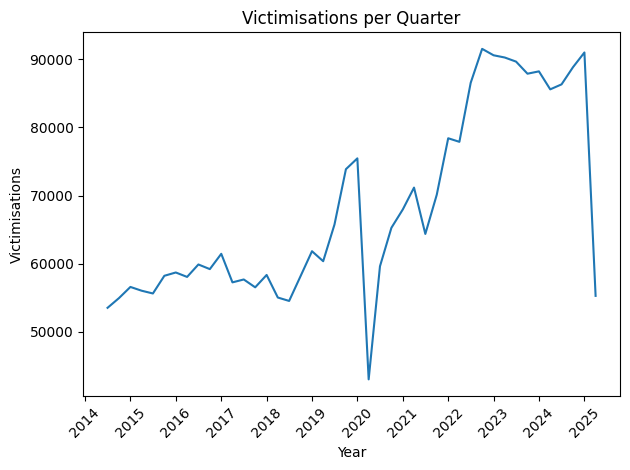

In [51]:
crime_by_quarter = police['Victimisations'].groupby(police['quarter_start']).sum()

fig, ax = plt.subplots()
ax.plot(crime_by_quarter.index, crime_by_quarter.values)

ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

title = "Victimisations per Quarter"

plt.xticks(rotation=45)
plt.xlabel("Year")
plt.ylabel("Victimisations")
plt.title(title)
plt.tight_layout()

plt.savefig(get_output_path(title + ".png"))

plt.show()

The number of crime victimisations since 2014 follows an interesting trend. Initially, from 2014, the number of victimisations remained reasonably constant, before beginning to increase dramatically in 2018. This increasing trend continued until 2023, when the number of crime victimisations stopped increasing again. There was a large anomaly in crime victimisations in 2020, likely due to the COVID lockdowns. This reduced the number of victimisations dramatically, but it only took about two years for the value to be back at 2019 levels. We think it makes sense to label COVID as an anomaly, as while this reduced crime temporarily due to an external factor, the underlying pattern of increasing crime remained.

## Seasonality for Police

Quarterly analysis of total victimisations is too infrequent to display a seasonal trend. The highest resolution of victimisation reporting is monthly. Aggregation is performed at this level to investigate if there is a seasonal pattern in crime victimisation. Note that this changes the scale on the y-axis.

In [52]:
from statsmodels.tsa.seasonal import STL

crime_by_month = police.groupby("Year Month")["Victimisations"].sum().reset_index()
crime_by_month["Year Month"] = pd.to_datetime(crime_by_month["Year Month"])

crime_by_month = crime_by_month.set_index("Year Month").asfreq("MS")

stl = STL(crime_by_month["Victimisations"], period=12, robust=True)
result = stl.fit()

trend = result.trend
seasonal = result.seasonal
residual = result.resid

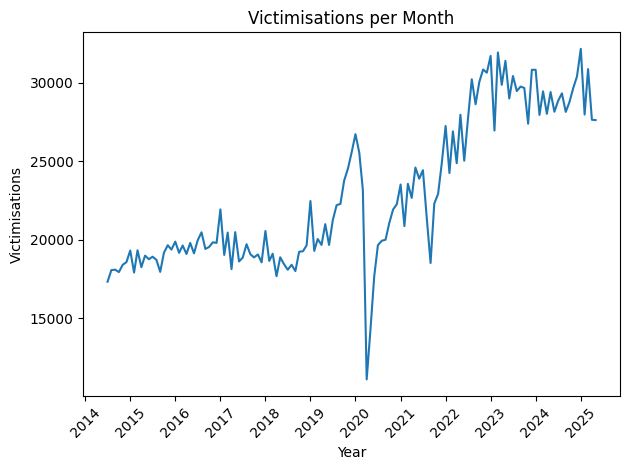

In [53]:
crime_by_month = police.groupby("Year Month")["Victimisations"].sum().reset_index()
crime_by_month["Year Month"] = pd.to_datetime(crime_by_month["Year Month"])

fig, ax = plt.subplots()
ax.plot(crime_by_month["Year Month"], crime_by_month["Victimisations"])

ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

plt.xticks(rotation=45)
plt.xlabel("Year")
plt.ylabel("Victimisations")

title = "Victimisations per Month"

plt.title(title)
plt.tight_layout()

plt.savefig(get_output_path(title + ".png"))

plt.show()

This chart follows the same pattern as quarterly victimisations, except at a higher resolution (monthly). There isn't an immediately obvious seasonal pattern. To investigate seasonality further, the time series can be broken into a seasonal, trend, and residual component, using "seasonal decomposition by Loess".

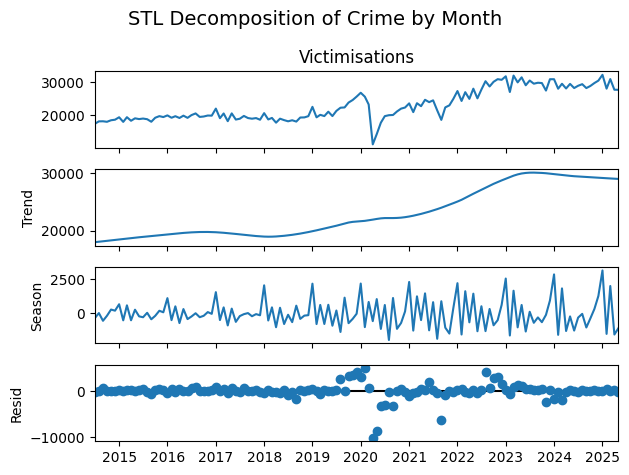

In [54]:
fig = result.plot()

title = "STL Decomposition of Crime by Month"

plt.suptitle(title, fontsize=14)
plt.tight_layout()

plt.savefig(get_output_path(title + ".png"))

plt.show()

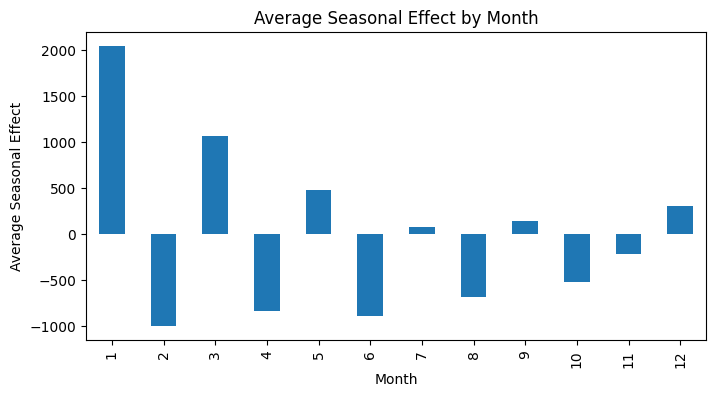

In [55]:
seasonal = result.seasonal
seasonal_by_month = seasonal.groupby(seasonal.index.month).mean()

plt.figure(figsize=(8,4))
seasonal_by_month.plot(kind="bar")

title = "Average Seasonal Effect by Month"

plt.title(title)
plt.xlabel("Month")
plt.ylabel("Average Seasonal Effect")

plt.savefig(get_output_path(title + ".png"))

plt.show()

Seasonal decomposition supports the initial observation that crime is, on average, increasing over time, as the trend component increases dramatically from 2018 to 2023. The seasonal component is messy, reasonably weak, and changing in amplitude over time. We expected that crime would increase through the summer months, and decrease over winter. This expectation was based on an assumption of more time spent with family and off work over summer months would result in an increase in domestic violence, especially with the stress of the Christmas period. To get a better understanding of the underlying seasonal pattern pattern, the seasonal effect at each month was averaged. This is displayed in the "Average Seasonal Effect by Month" chart. Instead of seeing crime victimisations increase in the summer months and reduce in the winter, we see an oscillating pattern instead, where the number of victimisations seems to be higher one month, then lower the next. The amplitude of these intra-year oscillations seems to decrease as the year progresses, but year-on-year, the amplitude of the seasonal pattern increases. This is a strange pattern which isn't explainable at first glance.

# Employment

To analyse the relationship between crime vicitimsations and employment rate, a dataset with a regional breakdown of employment levels was prepared. This dataset was sourced from Stats NZ here: https://datainfoplus.stats.govt.nz/Item/nz.govt.stats/b7c39358-aa03-446f-a27d-91c37caac35d#/nz.govt.stats/b7c39358-aa03-446f-a27d-91c37caac35d. This dataset contained no missing values, but required substantial filtering, and a pivot transformation to be in a suitable format and level of detail. The specifics of the data wrangling can be found in the respective notebook.

The following charts are based off the "percentage of the estimated working-age population who are employed". When matching this to total crime victimisations, it makes more sense to observe an "unemployment rate" rather than "employment rate", as it seems more likely that *unemployment* would form a positive relationship with crime victimisations. To find the unemployment rate as a percentage a column of, simply `100 - employment percentage` was calculated.

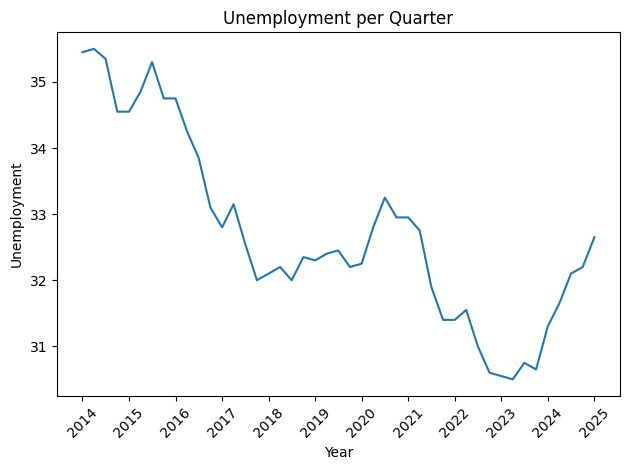

In [56]:
employment_post_2014 = employment[employment['year'] >= 2014]
employment_by_quarter = employment_post_2014[['quarter_start', 'Total All Regional Councils']]

unemployment = 100 - np.array(employment_by_quarter['Total All Regional Councils'])

fig, ax = plt.subplots()
ax.plot(employment_by_quarter['quarter_start'], unemployment)

ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

plt.xticks(rotation=45)
plt.xlabel("Year")
plt.ylabel("Unemployment")

title = "Unemployment per Quarter"

plt.title(title)
plt.tight_layout()

plt.savefig(get_output_path(title + ".png"))

plt.show()

Overall, unemployment trends in the opposite direction to crime victimisations. Generally since 2014, there has been a decrease in unemployment. Unemployment has clearly increased twice in this time range, once at the same time as the COVID-19 lockdowns, and then again from 2023 onwards. Additionally, employment was reasonably stable from 2017 until 2020.

It is worth noting that these unemployment figures are higher than what would typically be expected/reported. This figure is the "percentage of unemployed people, out of people aged 15 and over". Typically when discussing unemployment, the figure "percentage of people seeking work" is used instead. Percentage of unemployed people is a larger percentage value, as it doesn't account for people who are studying, full time parents, or unemployed by choice. In this study, unemployment rate is being used as a reflection of the overall economy, so provided this is reflected by the metric, the actual numeric value is of little importance.

## Regional Breakdown

Both the crime victimisations and employment datasets provide more detail at the regional level. A multiple-series line chart can be used to compare total crime victimisations and unemployment across different regions.

Initially, the police dataset reported by "Police Region", and the only detail that the unemployment dataset provided was the "district council". The police region and district council boundaries lined up closely, but police region further split up some council regions into smaller chunks. To handle this, the following changes were made.

#### Police Dataset
A different column "police distict merged" was created on the police dataset. The following changes were made:
- Police districts 'Auckland City', 'Counties/Manakau', and 'Waitemata' were merged to 'Auckland'.

#### Employment Dataset:
Regional councils were renamed to allow joining onto the police dataset.
- 'Gisborne/Hawke's Bay' was renamed to 'Eastern'
- 'Taranaki / Manawatu - Whanganui' was renamed to 'Central'
- 'Tasman / Nelson / Marlborough / West Coast' was renamed to 'Tasman'
- 'Otago / Southland' was renamed to 'Southern'

These changes allow the two datasets to be joined on the `police district merged` and `Regional Council` columns.

In [57]:
crime_by_quarter_regional = pd.DataFrame(police.groupby(['quarter_start', 'Police District Merged'])['Victimisations'].sum())

crime_by_quarter_regional_wide = (
    crime_by_quarter_regional
    .pivot_table(
        index=["quarter_start"],  # time-related columns
        columns="Police District Merged",
        values="Victimisations"
    )
    .reset_index()
    .sort_values("quarter_start")
)

crime_by_quarter_regional_wide["quarter_start"] = pd.to_datetime(crime_by_quarter_regional_wide["quarter_start"])

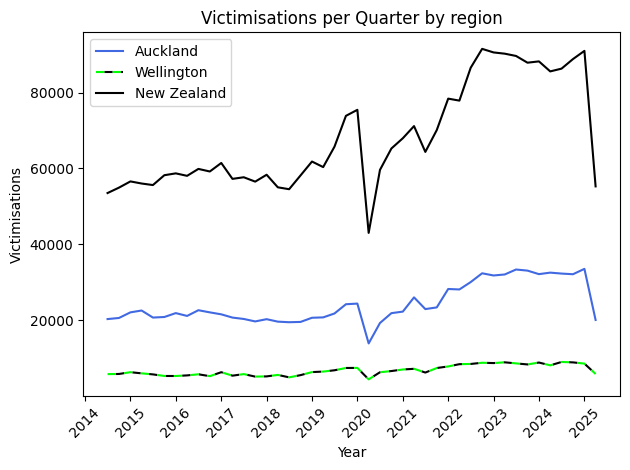

In [58]:
fig, ax = plt.subplots()
ax.plot(crime_by_quarter_regional_wide["quarter_start"], crime_by_quarter_regional_wide["Auckland"], label="Auckland", c="royalblue")
ax.plot(crime_by_quarter_regional_wide["quarter_start"], crime_by_quarter_regional_wide["Wellington"], label="Wellington", c="lime", dashes=[4, 4], gapcolor='black')
ax.plot(crime_by_quarter.index, crime_by_quarter.values, label="New Zealand", c="black")

ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

plt.xticks(rotation=45)
plt.xlabel("Year")
plt.ylabel("Victimisations")

title = "Victimisations per Quarter by region"

plt.title(title)
plt.legend()
plt.tight_layout()

plt.savefig(get_output_path(title + ".png"))

plt.show()

For EDA purposes, only total crime victimisations for 'Auckland', 'Wellington', and 'Total New Zealand' were plotted. All these series seemed to follow a similar trend. Auckland was more extreme than Wellington - i.e. both the reductions and increases in crime were more intense than what was observed in Wellington. It is likely that this is only a reflection of the larger population in Auckland. Further analysis would be required to see if more intense changes in economic conditions contributed to the large fluctuations in Auckland's crime victimisations.

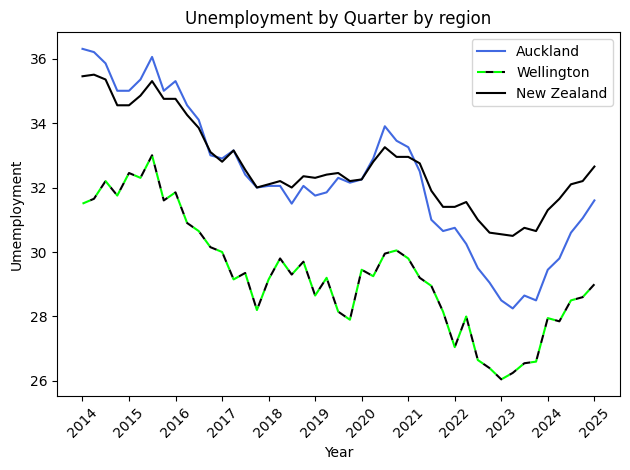

In [59]:
employment_post_2014 = employment[employment['year'] >= 2014]

fig, ax = plt.subplots()
ax.plot(employment_post_2014["quarter_start"], 100 - np.array(employment_post_2014['Auckland']), label="Auckland", c="royalblue")
ax.plot(employment_post_2014["quarter_start"], 100 - np.array(employment_post_2014["Wellington"]), label="Wellington", c="lime", dashes=[4, 4], gapcolor='black')
ax.plot(employment_post_2014['quarter_start'], 100 - np.array(employment_post_2014['Total All Regional Councils']), label="New Zealand", c="Black")

ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

plt.xticks(rotation=45)
plt.xlabel("Year")
plt.ylabel("Umemployment")

title = "Unemployment by Quarter by region"

plt.title(title)
plt.legend()
plt.tight_layout()

plt.savefig(get_output_path(title + ".png"))

plt.show()

As employment is reported as a percentage rather than an absolute value, the inter-region and nationwide unemployment levels are more easily comparable. It is interesting that Wellington has much lower unemployment than Auckland, even in recent times considering the public service cuts. Auckland seems to trend similarly to the New Zealand in terms of unemployment rate. This suggests that there are some other regions which have higher unemployment than the nationwide average - potentially significantly higher considering that Auckland makes up a considerable proportion of the total population.

Overall, the police and employment datasets seem to conform to expectation, in terms of trend when compared to major events such as COVID-19 and the cost of living crisis. There are some elements of the datasets which aren't immediately explainable, such as the seasonal component of crime victimisations, which follows a strange oscillatory pattern. The datasets appear ready for inter-region temporal analysis.